In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import random
import napari
import tifffile
#import napari_bleach_correct
from tqdm import tqdm
from skimage.measure import find_contours, perimeter
python_test = __import__('0_python_test')
from scipy.signal import find_peaks
from scipy import ndimage
import cv2
import pickle
from pprint import pprint
import time

In [10]:
viewer = napari.Viewer()

In [11]:
# Paths to data
mask_path = 'D:\\Bestun\\masks_tracked\\ModelTest\\'
tif_path = 'D:\\Bestun\\raw_data\\ModelTest\\'
output_path = 'D:\\Bestun\\output_path\\ModelTest\\'

tifs = os.listdir(tif_path)
outs = os.listdir(output_path)

while True:
    tif = '021024_cluster_3.tif'
    print(tif)
    if tif[:-4] + '.pkl' not in outs:
        break

021024_cluster_3.tif


In [12]:
X = tifffile.imread(tif_path + tif[:-4] + '.tif')
print(X.shape)
viewer.add_image(X, name='raw') 
Y = tifffile.imread(mask_path + tif[:-4] + '.tif')

# Get common cells
occurrence_limit = 80 # Include only cells that are present in at least 80% of frames
common_cells, counts = python_test.get_common_cells(Y, occurrence=occurrence_limit) # Get the cells to include in the intensity measurements
print(f"Common cells: {len(common_cells)}")

#Set all labels in masks not in common_cells to 0."""
filter = np.isin(Y, common_cells)
Y[~filter] = 0
viewer.add_labels(Y, name='mask', opacity=0.35)


(1441, 512, 512)
Common cells: 33


<Labels layer 'mask' at 0x2ae5ffeb250>

### Creating the points layer

Before you advance with the next cell you need to press the button to create a *New points layer*.

Continue with locating incorrectly placed labels, if they exist, by first clicking the "Add points"-button to then click the different incorrectly placed labels.

Run the next cell to create a new *mask2* layer with the incorrectly placed labels removed.

In [13]:
# get the points layer
points_layer = viewer.layers[2].data.astype(np.uint16)
labels_at_points = Y[points_layer[:,0], points_layer[:,1], points_layer[:,2]]

# remove all labels from Y if in labels_at_points
Y = np.where(np.isin(Y, labels_at_points), 0, Y)
viewer.add_labels(Y, name='mask2', opacity=0.35)

<Labels layer 'mask2' at 0x2ae1a7bd040>

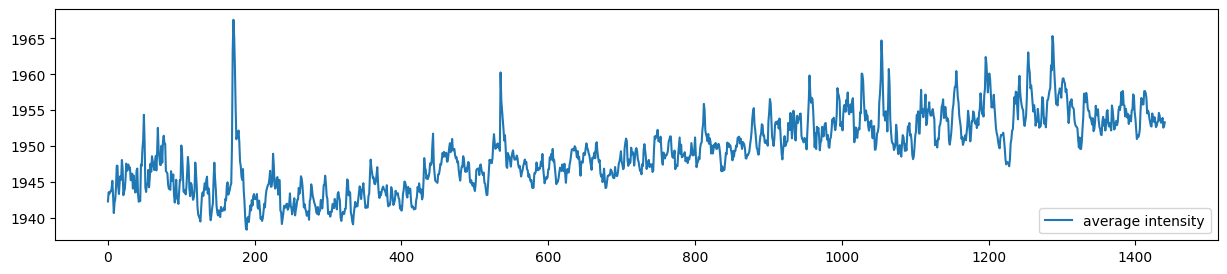

In [14]:
# get average intensity
avg = np.mean(X, axis=(1,2))  # average intensity across all cells
plt.figure(figsize=(15, 3))
plt.plot([t for t in range(len(avg))], avg, label='average intensity')
plt.legend()

In [15]:
#Version 2, debugged issue with NaN values in cross-correlation calculation

def get_cell_intensities(c, Y, X):
    intensities = np.full(X.shape[0], np.NaN)  # Default to NaN

    for t in range(X.shape[0]):
        X[t] = np.nan_to_num(X[t], nan=0, posinf=0, neginf=0)
        Y[t] = np.nan_to_num(Y[t], nan=0, posinf=0, neginf=0)

        intensies = X[t][Y[t] == c]
        if len(intensies) > 0:
            intensities[t] = np.nanmean(intensies)

    # Handle missing intensities
    lost_intsies_idx = np.where(np.isnan(intensities))[0]
    if len(lost_intsies_idx) > 0:
        lost_intsies_idx = np.array_split(lost_intsies_idx, np.where(np.diff(lost_intsies_idx) != 1)[0] + 1)
        
        # Attempt interpolation
        for idxs in lost_intsies_idx:
            start_idx = max(0, idxs[0] - 1)
            end_idx = min(X.shape[0] - 1, idxs[-1] + 1)
            area = np.multiply(Y[start_idx] == c, Y[end_idx] == c)

            for i in idxs:
                if np.any(X[i][area]):
                    intensities[i] = np.nanmean(X[i][area])

    # Replace remaining NaNs with the mean intensity over the valid time points
    cell_mean_intensity = np.nanmean(intensities)
    intensities[np.isnan(intensities)] = cell_mean_intensity

    return intensities


def get_cell_intensities_circle(c, Y, X, radius):
    intensities = np.full(X.shape[0], np.NaN)  # Default to NaN
    com_mask = np.zeros(Y.shape, dtype=np.uint8)

    for t in range(X.shape[0]):
        X[t] = np.nan_to_num(X[t], nan=0, posinf=0, neginf=0)
        Y[t] = np.nan_to_num(Y[t], nan=0, posinf=0, neginf=0)

        if not np.any(Y[t] == c):
            continue

        com = ndimage.center_of_mass(Y[t] == c)
        if np.isnan(com[0]) or np.isnan(com[1]):
            continue

        xx, yy = np.mgrid[:X.shape[1], :X.shape[2]]
        circle = (xx - com[0]) ** 2 + (yy - com[1]) ** 2
        com_mask[t] = circle < radius ** 2

        intensity_circle = X[t][com_mask[t] == 1]
        if len(intensity_circle) > 0:
            intensities[t] = np.nanmean(intensity_circle)

    # Interpolate and fill remaining NaNs
    lost_intsies_idx = np.where(np.isnan(intensities))[0]
    if len(lost_intsies_idx) > 0:
        lost_intsies_idx = np.array_split(lost_intsies_idx, np.where(np.diff(lost_intsies_idx) != 1)[0] + 1)

        for idxs in lost_intsies_idx:
            start_idx = max(0, idxs[0] - 1)
            end_idx = min(X.shape[0] - 1, idxs[-1] + 1)
            area = np.multiply(Y[start_idx] == c, Y[end_idx] == c)

            for i in idxs:
                if np.any(X[i][area]):
                    intensities[i] = np.nanmean(X[i][area])

    # Replace remaining NaNs with the cell's mean intensity
    cell_mean_intensity = np.nanmean(intensities)
    intensities[np.isnan(intensities)] = cell_mean_intensity

    com_mask[com_mask != 0] = c
    return com_mask, intensities


#Latest version of the function
def do_it2(X, Y, occurrence_limit=80, radius=10):
    if X.shape != Y.shape:
        raise ValueError("X and Y must have the same shape.")

    d = {}
    com_mask_all = np.zeros(Y.shape, dtype=np.uint8)

    for c in tqdm(np.unique(Y)[1:]):
        com_mask, intensities_circle = get_cell_intensities_circle(c, Y, X, radius)
        com_mask_all += com_mask

        intensities = get_cell_intensities(c, Y, X)
        d[c] = {'intensities': intensities, 
                'intensities_circle': intensities_circle, 
                'occurrence_limit': occurrence_limit,
                'circle_radius': radius}

    viewer.add_labels(com_mask_all, name='com_mask_all')
    return d


# Example usage
d = do_it2(X, Y, occurrence_limit=occurrence_limit)

100%|██████████| 33/33 [04:48<00:00,  8.74s/it]


In [16]:
def check_for_nans_in_dict(d):
    """
    Loop through the dictionary 'd' and check for NaN values in 'intensities' and 'intensities_circle'.
    """
    print("Starting NaN check for dictionary...")  # Debugging statement
    
    # Loop through the dictionary items
    for cell_label, cell_data in d.items():
        print(f"Inspecting cell: {cell_label}")  # Debugging statement
        
        # Check if the value for this cell is a dictionary
        if isinstance(cell_data, dict):
            # Check for 'intensities' key and NaNs
            if 'intensities' in cell_data:
                intensities = cell_data['intensities']
                if np.any(np.isnan(intensities)):
                    print(f"  NaN values found in 'intensities' for cell {cell_label}.")
                else:
                    print(f"  No NaN values in 'intensities' for cell {cell_label}.")
            else:
                print(f"  Key 'intensities' not found for cell {cell_label}.")
            
            # Check for 'intensities_circle' key and NaNs
            if 'intensities_circle' in cell_data:
                intensities_circle = cell_data['intensities_circle']
                if np.any(np.isnan(intensities_circle)):
                    print(f"  NaN values found in 'intensities_circle' for cell {cell_label}.")
                else:
                    print(f"  No NaN values in 'intensities_circle' for cell {cell_label}.")
            else:
                print(f"  Key 'intensities_circle' not found for cell {cell_label}.")
        else:
            # If the value is not a dictionary
            print(f"Cell {cell_label} data is not a dictionary; it is of type {type(cell_data)}.")  # Debugging statement
            print(f"  Raw data: {cell_data}")  # Debugging statement for further inspection
            
    print("Finished checking for NaN values.")  # Debugging statement

# Example usage
check_for_nans_in_dict(d)

Starting NaN check for dictionary...
Inspecting cell: 1
  No NaN values in 'intensities' for cell 1.
  No NaN values in 'intensities_circle' for cell 1.
Inspecting cell: 2
  No NaN values in 'intensities' for cell 2.
  No NaN values in 'intensities_circle' for cell 2.
Inspecting cell: 4
  No NaN values in 'intensities' for cell 4.
  No NaN values in 'intensities_circle' for cell 4.
Inspecting cell: 7
  No NaN values in 'intensities' for cell 7.
  No NaN values in 'intensities_circle' for cell 7.
Inspecting cell: 8
  No NaN values in 'intensities' for cell 8.
  No NaN values in 'intensities_circle' for cell 8.
Inspecting cell: 9
  No NaN values in 'intensities' for cell 9.
  No NaN values in 'intensities_circle' for cell 9.
Inspecting cell: 10
  No NaN values in 'intensities' for cell 10.
  No NaN values in 'intensities_circle' for cell 10.
Inspecting cell: 12
  No NaN values in 'intensities' for cell 12.
  No NaN values in 'intensities_circle' for cell 12.
Inspecting cell: 15
  No NaN 

In [17]:
# save pkl
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

pkl_name = output_path + tif[:-4] + '.pkl'
with open(pkl_name, 'wb') as f:
    pickle.dump(d, f)
    print(f'pkl saved to {pkl_name}')

pkl saved to D:\Bestun\output_path\ModelTest\021024_cluster_3.pkl
